### Import Libraries

In [2]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import pingouin as pg
from scipy import stats
import re

sns.set_theme(style="whitegrid", palette="viridis")

### Import Dataset

In [3]:
df = pd.read_csv('examples/energibridge-profiling/experiments/experiment2.0/all_run_tables_combined.csv')
columns_to_remove = ['sampling', '__run_id', '__done']
df.drop(columns_to_remove, axis=1, inplace=True)

df["experiment_name"] = df["experiment_name"].astype(str).str.replace("code_func", "code_function")

algorithms = [
    "dijkstra",
    "edit_distance",
    "fibonacci",
    "floyd",
    "knapsack",
    "levenshtein_distance",
    "longest_common_subsequence",
    "matrix_chain_multiplication",
    "matrix_chain_order",
    "rod_cutting",
]

def extract_base_algo(name):
    name_lower = name.lower()
    for algo in algorithms:
        if algo in name_lower:
            return algo
    return "unknown"

df["base_algo"] = df["experiment_name"].apply(extract_base_algo)

methods = [
    "code_function",
    "code_native",
    "native_function",
    "code",
    "function",
    "multi",
    "native",
    "network",
    "object",
    "other",
    "origin",
    "mixed",
]

def extract_methods(name):
    name_lower = name.lower()
    for algo in methods:
        if algo in name_lower:
            return algo
    return "unknown"

df["optimize_method"] = df["experiment_name"].apply(extract_methods)
df["optimize_method"] = df["optimize_method"].astype(str).str.replace("_", ",")

df.head()

,experiment_name,repetition,execution_time_ms,cpu_usage_percent,memory_usage_mb,cpu_energy_j,base_algo,optimize_method
0,floyd_function_experiment,1,5860.892,6.862,2740.151,63.623,floyd,function
1,floyd_function_experiment,2,5854.223,6.701,2752.842,64.281,floyd,function
2,floyd_function_experiment,3,5860.133,6.726,2770.630,65.697,floyd,function
3,floyd_function_experiment,4,5856.936,6.331,2749.098,64.335,floyd,function
4,floyd_function_experiment,5,6149.821,6.343,2747.783,67.977,floyd,function


In [5]:
df["base_algo"].unique()

array(['floyd', 'rod_cutting', 'knapsack', 'levenshtein_distance',
       'dijkstra', 'matrix_chain_multiplication', 'edit_distance',
       'fibonacci', 'longest_common_subsequence', 'matrix_chain_order'],
      dtype=object)

In [6]:
df["optimize_method"].unique()

array(['function', 'native', 'other', 'object', 'origin', 'multi',
       'mixed', 'code', 'native,function', 'code,native', 'network',
       'code,function'], dtype=object)

### Data Analysis

In [25]:
df = pd.read_csv("cleaned_experiment_results.csv")


In [26]:
metrics = ["execution_time_ms", "cpu_usage_percent", "memory_usage_mb", "cpu_energy_j"]

summary = (
    df.groupby(["base_algo", "optimize_method"])[metrics]
      .agg(["mean", "median", "std"])
      .round(3)
)

display(summary)


execution_time_ms                    \
                                         mean    median     std   
base_algo   optimize_method                                       
dijkstra    code                       70.922    70.628   0.864   
            function                   55.254    55.234   0.782   
            mixed                      45.739    45.939   1.121   
            multi                    9134.276  9103.400  96.065   
            native                   1661.449  1662.805  15.866   
...                                       ...       ...     ...   
rod_cutting mixed                      65.183    65.078   0.431   
            native                     64.790    64.522   0.848   
            object                   6209.060  6208.884  27.705   
            origin                   3687.889  3687.018   9.253   
            other                    1300.277  1302.010   7.722   

                            cpu_usage_percent                memory_usage_mb  \
                                         mean  median    std            mean   
base_algo   optimize_method                                                    
dijkstra    code                        4.901   4.782  0.547        2755.223   
            function                    4.818   4.741  0.701        2739.493   
            mixed                       4.286   4.558  0.872        2720.402   
            multi                       6.443   6.578  0.312        2739.835   
            native                      8.147   8.262  0.590        2773.053   
...                                       ...     ...    ...             ...   
rod_cutting mixed                       9.834  10.349  1.202        2872.223   
            native                     10.250  10.574  0.919        2869.911   
            object                      6.359   6.329  0.148        2817.525   
            origin                      6.342   6.430  0.444        2888.373   
            other                       9.504   9.483  0.909        2826.927   

                                              cpu_energy_j                 
                               median     std         mean  median    std  
base_algo   optimize_method                                                
dijkstra    code             2753.446   5.057        3.503   3.456  0.191  
            function         2740.623  13.622        3.426   3.410  0.366  
            mixed            2716.990   8.538        3.337   3.260  0.261  
            multi            2743.232  17.805       85.962  85.731  1.088  
            native           2768.537  17.624       35.916  35.948  0.411  
...                               ...     ...          ...     ...    ...  
rod_cutting mixed            2881.673  28.890       10.168  10.244  0.237  
            native           2865.901  34.825       10.288  10.204  0.370  
            object           2814.854  12.072       76.838  76.806  1.407  
            origin           2884.475  17.717       42.483  41.802  1.945  
            other            2826.510   9.549       16.509  16.456  0.511  

[82 rows x 12 columns]

In [27]:
summary_reset = summary.reset_index()
summary_reset.columns = ['_'.join(col).strip('_') for col in summary_reset.columns.values]
display(summary_reset.head())


,base_algo,optimize_method,execution_time_ms_mean,execution_time_ms_median,execution_time_ms_std,cpu_usage_percent_mean,cpu_usage_percent_median,cpu_usage_percent_std,memory_usage_mb_mean,memory_usage_mb_median,memory_usage_mb_std,cpu_energy_j_mean,cpu_energy_j_median,cpu_energy_j_std
0,dijkstra,code,70.922,70.628,0.864,4.901,4.782,0.547,2755.223,2753.446,5.057,3.503,3.456,0.191
1,dijkstra,function,55.254,55.234,0.782,4.818,4.741,0.701,2739.493,2740.623,13.622,3.426,3.410,0.366
2,dijkstra,mixed,45.739,45.939,1.121,4.286,4.558,0.872,2720.402,2716.990,8.538,3.337,3.260,0.261
3,dijkstra,multi,9134.276,9103.400,96.065,6.443,6.578,0.312,2739.835,2743.232,17.805,85.962,85.731,1.088
4,dijkstra,native,1661.449,1662.805,15.866,8.147,8.262,0.590,2773.053,2768.537,17.624,35.916,35.948,0.411


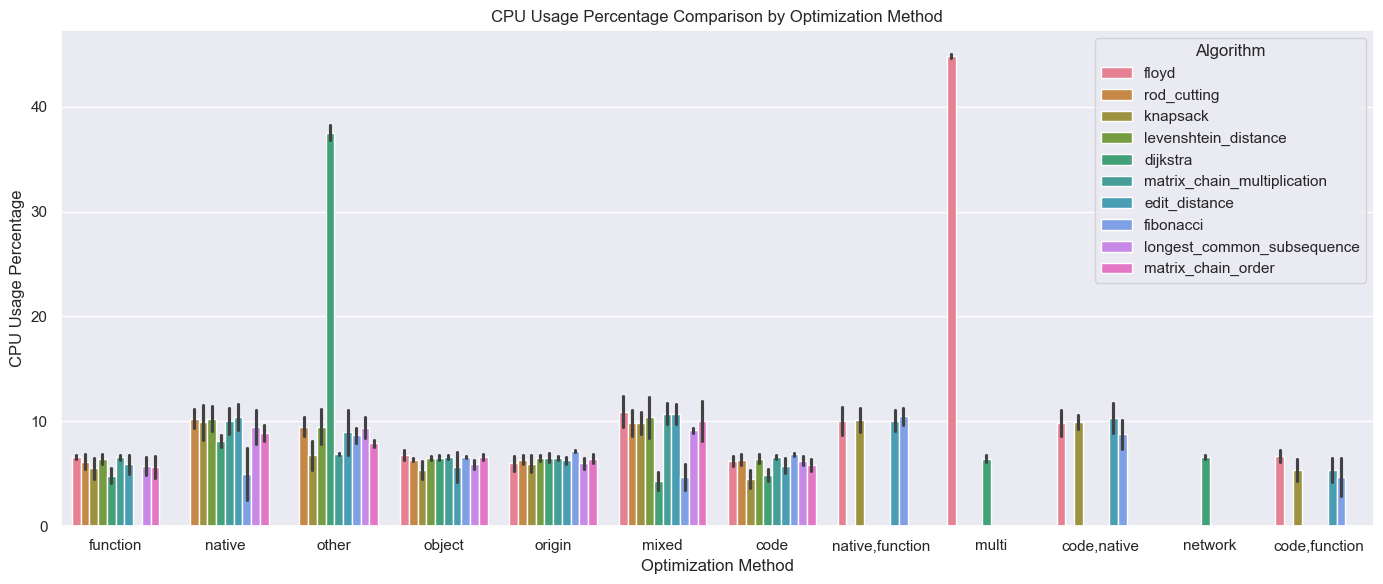

In [29]:
plt.figure(figsize=(14,6))
sns.barplot(
    data=df,
    x="optimize_method",
    y="cpu_usage_percent",
    hue="base_algo",
    estimator=np.mean,
    errorbar="sd",
)
plt.title("CPU Usage Percentage Comparison by Optimization Method")
plt.ylabel("CPU Usage Percentage")
plt.xlabel("Optimization Method")
plt.legend(title="Algorithm")
plt.tight_layout()
plt.show()


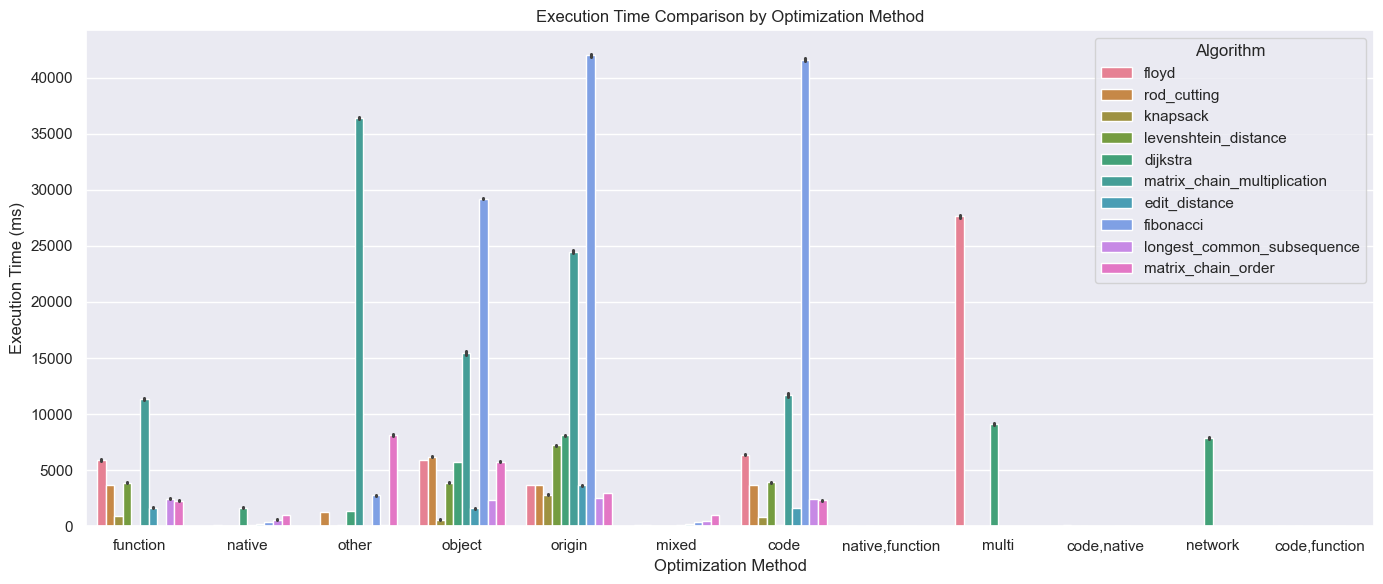

In [30]:
plt.figure(figsize=(14,6))
sns.barplot(
    data=df,
    x="optimize_method",
    y="execution_time_ms",
    hue="base_algo",
    estimator=np.mean,
    errorbar="sd",
)
plt.title("Execution Time Comparison by Optimization Method")
plt.ylabel("Execution Time (ms)")
plt.xlabel("Optimization Method")
plt.legend(title="Algorithm")
plt.tight_layout()
plt.show()


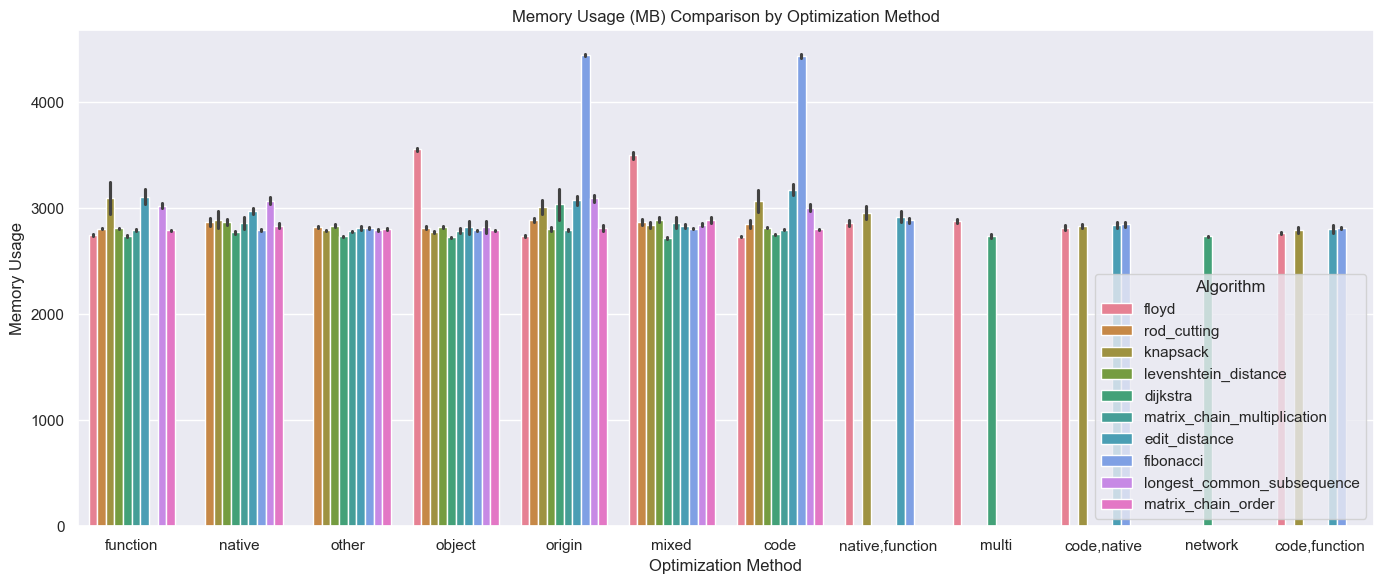

In [31]:
plt.figure(figsize=(14,6))
sns.barplot(
    data=df,
    x="optimize_method",
    y="memory_usage_mb",
    hue="base_algo",
    estimator=np.mean,
    errorbar="sd",
)
plt.title("Memory Usage (MB) Comparison by Optimization Method")
plt.ylabel("Memory Usage")
plt.xlabel("Optimization Method")
plt.legend(title="Algorithm")
plt.tight_layout()
plt.show()


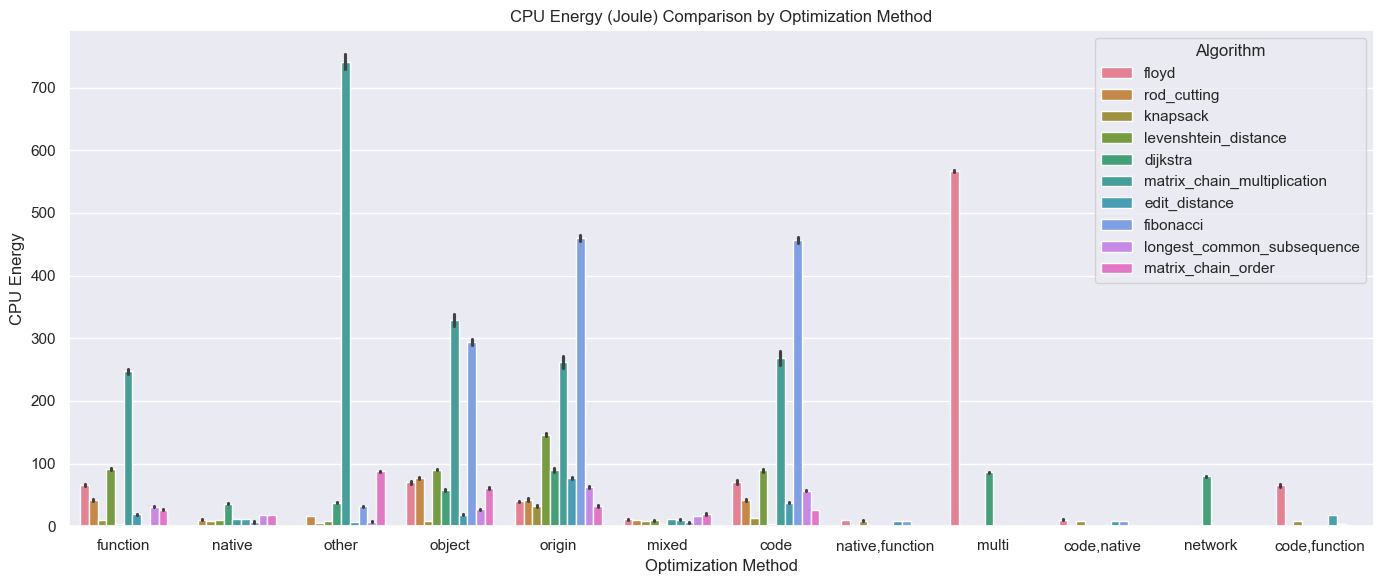

In [32]:
plt.figure(figsize=(14,6))
sns.barplot(
    data=df,
    x="optimize_method",
    y="cpu_energy_j",
    hue="base_algo",
    estimator=np.mean,
    errorbar="sd",
)
plt.title("CPU Energy (Joule) Comparison by Optimization Method")
plt.ylabel("CPU Energy")
plt.xlabel("Optimization Method")
plt.legend(title="Algorithm")
plt.tight_layout()
plt.show()


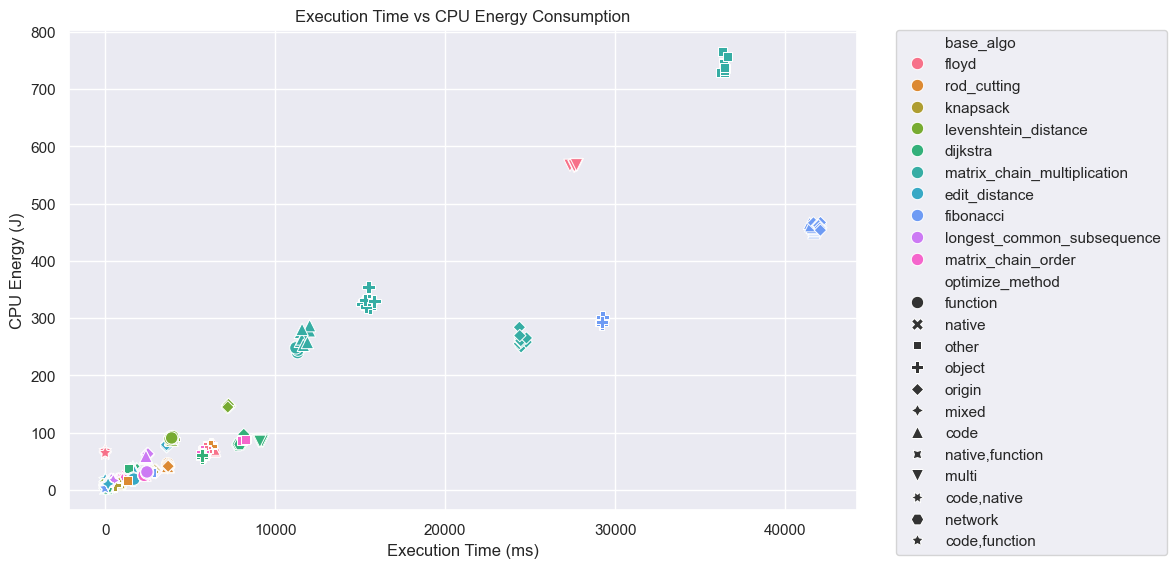

In [33]:
plt.figure(figsize=(12,6))  # wider figure
sns.scatterplot(
    data=df,
    x="execution_time_ms",
    y="cpu_energy_j",
    hue="base_algo",
    style="optimize_method",
    s=80
)

plt.title("Execution Time vs CPU Energy Consumption")
plt.xlabel("Execution Time (ms)")
plt.ylabel("CPU Energy (J)")

# Move legend outside the plot on the right
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', borderaxespad=0.)
plt.tight_layout()  # prevent clipping
plt.show()


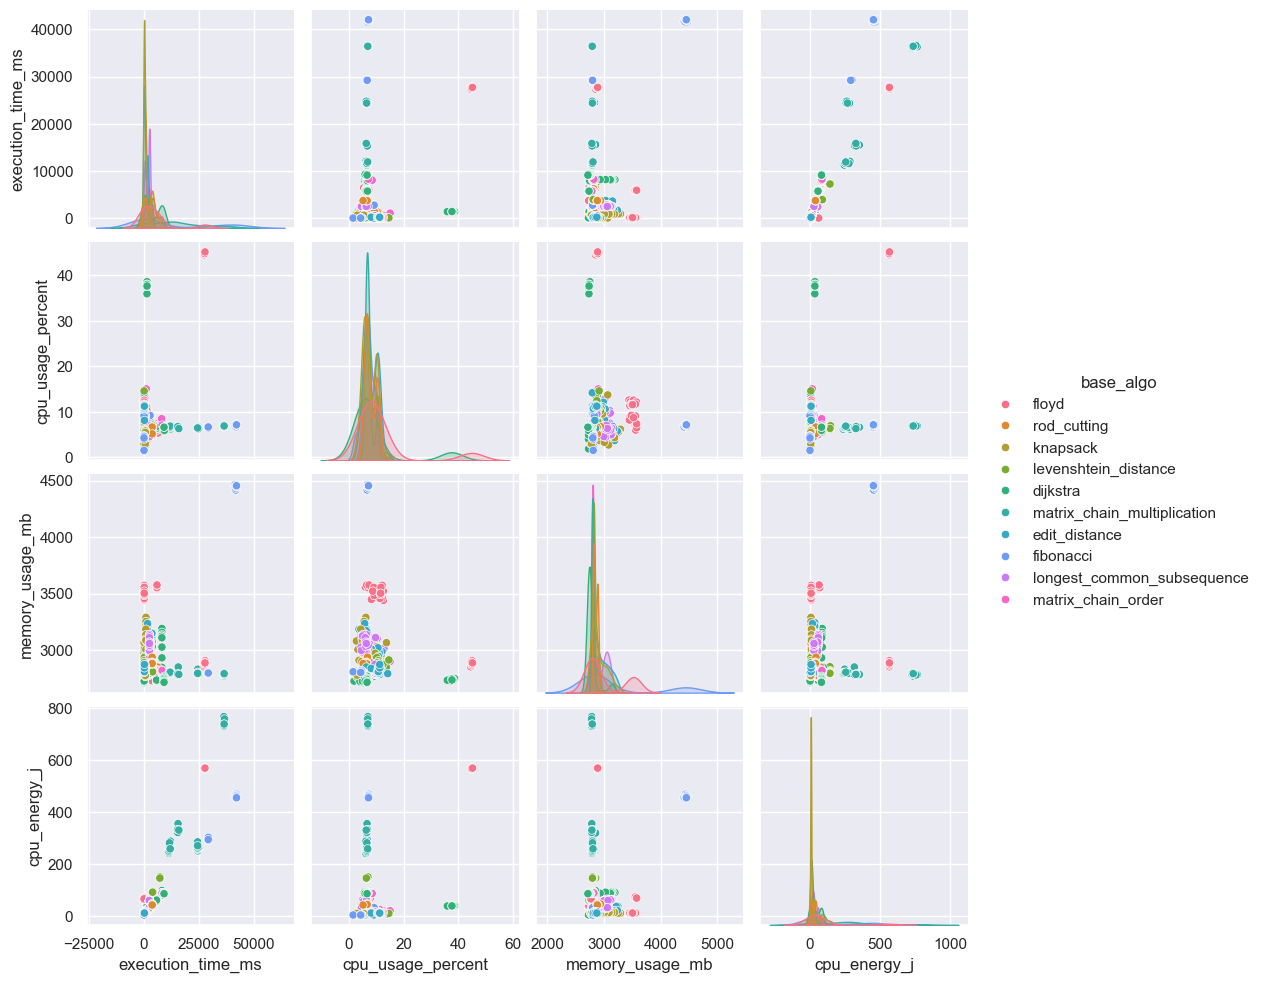

In [34]:
sns.pairplot(df, vars=["execution_time_ms", "cpu_usage_percent", "memory_usage_mb", "cpu_energy_j"], hue="base_algo")
plt.show()


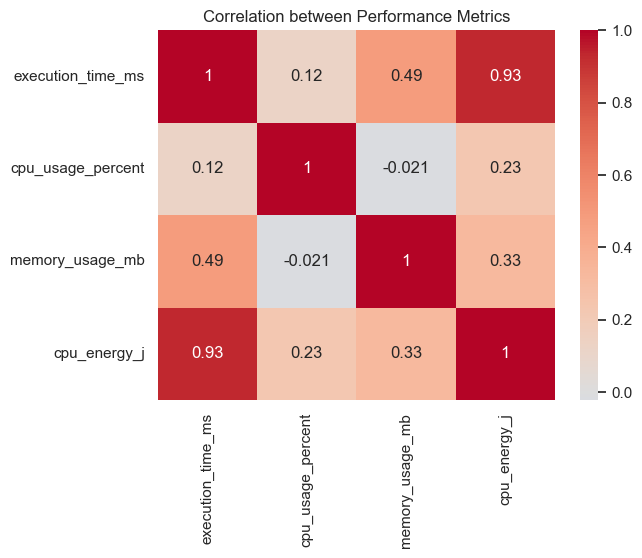

In [35]:
corr = df[["execution_time_ms","cpu_usage_percent","memory_usage_mb","cpu_energy_j"]].corr()
sns.heatmap(corr, annot=True, cmap="coolwarm", center=0)
plt.title("Correlation between Performance Metrics")
plt.show()


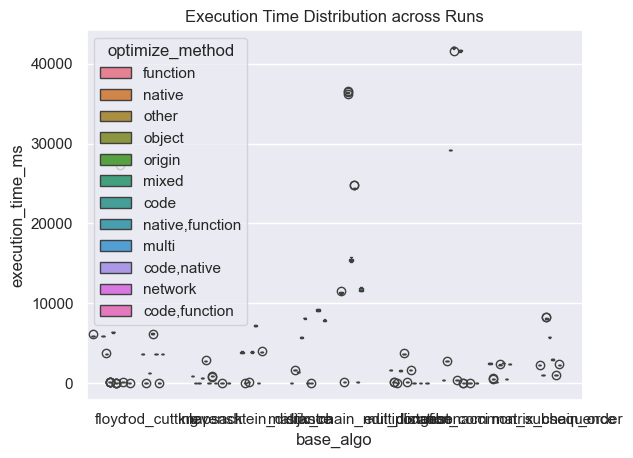

In [36]:
sns.boxplot(data=df, x="base_algo", y="execution_time_ms", hue="optimize_method")
plt.title("Execution Time Distribution across Runs")
plt.show()


C:\Users\ZhaohanGao\AppData\Local\Temp\ipykernel_7364\3843376597.py:20: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar='sd'` for the same effect.

  sns.barplot(


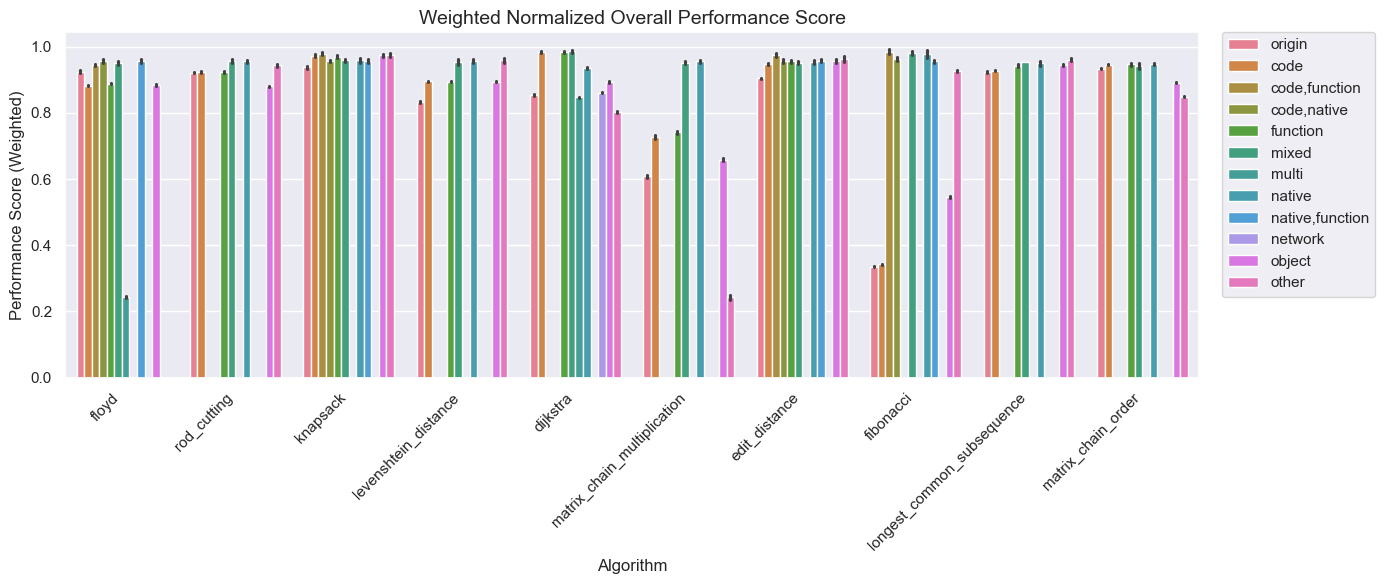

In [39]:
# 归一化
for col in ["execution_time_ms","cpu_usage_percent","memory_usage_mb","cpu_energy_j"]:
    df[col + "_norm"] = (df[col] - df[col].min()) / (df[col].max() - df[col].min())

# 设置权重（CPU usage 比重降低）
w_time = 0.4
w_cpu = 0.2
w_energy = 0.4

df["performance_score"] = 1 - (
    w_time * df["execution_time_ms_norm"] +
    w_cpu  * df["cpu_usage_percent_norm"] +
    w_energy * df["cpu_energy_j_norm"]
)

# 绘图
method_order = ["origin"] + sorted([m for m in df["optimize_method"].unique() if m != "origin"])

plt.figure(figsize=(14,6))
sns.barplot(
    data=df,
    x="base_algo",
    y="performance_score",
    hue="optimize_method",
    hue_order=method_order,
    ci="sd"
)
plt.title("Weighted Normalized Overall Performance Score", fontsize=14)
plt.xlabel("Algorithm", fontsize=12)
plt.ylabel("Performance Score (Weighted)", fontsize=12)
plt.xticks(rotation=45, ha="right")
plt.legend(bbox_to_anchor=(1.02, 1), loc='upper left', borderaxespad=0.)
plt.tight_layout()
plt.show()
